# Import libraries

In [66]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display


## Import Functions

### dslabs_functions

In [67]:
%run "scripts/dslabs_functions.py"

dslabs_functions lodaded


### data functions

In [3]:
%run "scripts/data_functions.py"


dslabs_functions lodaded
data_functions lodaded


# Load

In [68]:

#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase
filepath = r'data/citi_bike_data_prep_scaling_no_outliers.csv'


file_tag = 'Citi Bike'

#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase

In [69]:
test_data = True
# test_data = False

# Load the data
if test_data:
    df = pd.read_csv(filepath, na_values="")

    df: DataFrame = df.sample(frac=0.0015, replace = False)

else:
    # If not test_data, load the entire dataset
    df = pd.read_csv(filepath)

#id_cols=['ride_id','start_time', 'end_time','start_station','end_station','start_station_id','end_station_id','start_lat','start_lng', 'end_lat', 'end_lng','wmo_weather_code','snowfall_cm','ride_duration_sec']
##remove also col = 'snowfall_cm' because it has only 0 values in our dataset
##remove also start_station and end_Station = they have too many unique values(around 2k) which will make the encoding process very slow
#
#df=df.drop(columns=id_cols, axis=1)

df.head(10)
display(df.shape)

(4568, 39)

In [70]:
# Verificar se 'event_time' está presente e é do tipo datetime
if 'event_time' in df.columns and pd.api.types.is_datetime64_any_dtype(df['event_time']):
    # Conta o número de dias únicos
    num_unique_days = df['event_time'].nunique()
    print(f"Número de dias únicos: {num_unique_days}")
else:
    print("A coluna 'event_time' não existe ou não é do tipo datetime.")

# Contar valores distintos em todas as colunas
distinct_values = df.nunique()
print("Número de valores distintos por coluna:")
print(distinct_values)

A coluna 'event_time' não existe ou não é do tipo datetime.
Número de valores distintos por coluna:
bike_type                                2
user_type                                2
day_of_month                            30
is_weekend                               2
ride_duration_min                     4555
temperature_2m                         205
rain_mm                                 12
cloud_cover_low_pct                     68
wind_speed_10m                         237
ride_distance_km                      4468
ride_avg_speed                        4510
time_of_day_sin                          6
time_of_day_cos                          5
day_of_week_sin                          7
day_of_week_cos                          7
hour_sin                                13
hour_cos                                13
start_borough_Bronx                      2
start_borough_Brooklyn                   2
start_borough_Jersey City                1
start_borough_Manhattan                 

# Cluster Data Preparation
- To apply clustering thecniques we need to apply specific date preparation thecniques, like scaling, drop of outliers and also feature selection

## Drop Outliers

## Scaling

In [45]:
variable_types: dict[str, list] = get_variable_types(df)

numeric: list[str] = variable_types["numeric"]

In [12]:
summary5: DataFrame = df[numeric].describe(include="all")
summary5

,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
count,3.193597e+06,3.193597e+06,3.193597e+06,3.193597e+06,3.193597e+06,3.193597e+06,3.193597e+06,3.193597e+06,3.193597e+06,3.193597e+06,3.193597e+06,3.193597e+06,3.193597e+06,3.193597e+06
mean,-1.406714e-16,3.663072e-16,-2.123763e-15,8.932965e-17,2.675217e-17,-4.317014e-16,5.117087e-16,-5.856020e-16,6.150174e-17,1.991729e-17,-1.276513e-16,1.361638e-17,1.311889e-16,6.214585e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.894702e+00,-5.799339e-01,-2.370250e+00,-2.179325e-01,-5.731856e-01,-2.025832e+00,-1.145757e+00,-1.955610e+00,-1.296877e+00,-1.416769e+00,-1.560851e+00,-1.422224e+00,-1.018931e+00,-1.184091e+00
25%,-8.059802e-01,-3.790000e-01,-7.760109e-01,-2.179325e-01,-5.731856e-01,-7.506248e-01,-6.662833e-01,-4.834875e-01,-1.296877e+00,-4.841035e-01,-1.258007e+00,-8.864974e-01,-9.698052e-01,-9.526685e-01
50%,4.080375e-02,-1.952994e-01,-1.117444e-01,-2.179325e-01,-5.731856e-01,-7.143835e-02,-2.964251e-01,-1.343806e-03,-1.852400e-01,1.269325e-02,-1.813812e-01,-1.906061e-02,-2.964966e-01,-3.205739e-01
75%,8.875877e-01,1.306047e-01,7.612915e-01,-2.179325e-01,9.720291e-04,6.631919e-01,3.454224e-01,5.045365e-01,1.213145e+00,1.269325e-02,8.202280e-01,1.058264e+00,8.001585e-01,5.429432e-01
max,1.734372e+00,7.150365e+01,2.848986e+00,1.735723e+01,2.297602e+00,3.379938e+00,1.347814e+01,1.364496e+02,1.313964e+00,1.690554e+00,1.206424e+00,1.508861e+00,1.870806e+00,2.269978e+00


In [13]:
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
citibike_numeric_features = df[numeric]

# Normalize the data
scaler = StandardScaler()
citibike_numeric_features_scaled = scaler.fit_transform(citibike_numeric_features)

In [16]:
display(citibike_numeric_features_scaled)

array([[ 1.25049506, -0.1861314 ,  0.22987832, ...,  0.21871395,
         0.05171669, -1.12537191],
       [ 1.0085568 , -0.40437003, -0.35847199, ..., -1.42222404,
        -0.59558433, -0.67807003],
       [-1.2898567 , -0.29692256, -0.66213666, ...,  0.21871395,
         0.80015849, -1.12537191],
       ...,
       [-0.80598017, -0.30721582, -0.18766061, ..., -1.05822349,
         1.67719358, -0.32057393],
       [-0.9269493 ,  0.28940508,  1.04597714, ..., -0.01906061,
        -0.96980523,  0.09564133],
       [ 1.0085568 , -0.50927898, -0.5862205 , ..., -1.42222404,
         0.80015849, -1.12537191]])

## Feature selection

# Cluster Application Techinques 

## K means Clustering

### Elbow method study

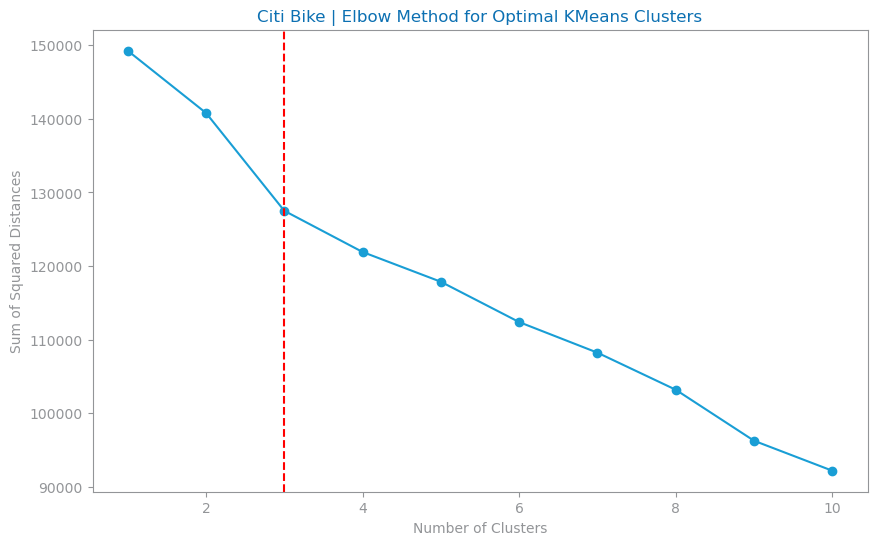

In [71]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Define the range of clusters to evaluate
range_n_clusters = list(range(1, 11))

# Initialize an empty list to store the sum of squared distances
ssd = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df)
    ssd.append(kmeans.inertia_)

# Determine the elbow point using KneeLocator
kneedle = KneeLocator(range_n_clusters, ssd, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, marker='o')
plt.title(f'{file_tag} | Elbow Method for Optimal KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, color='r', linestyle='--')

plt.show()

### Sillhouete study for kmeans

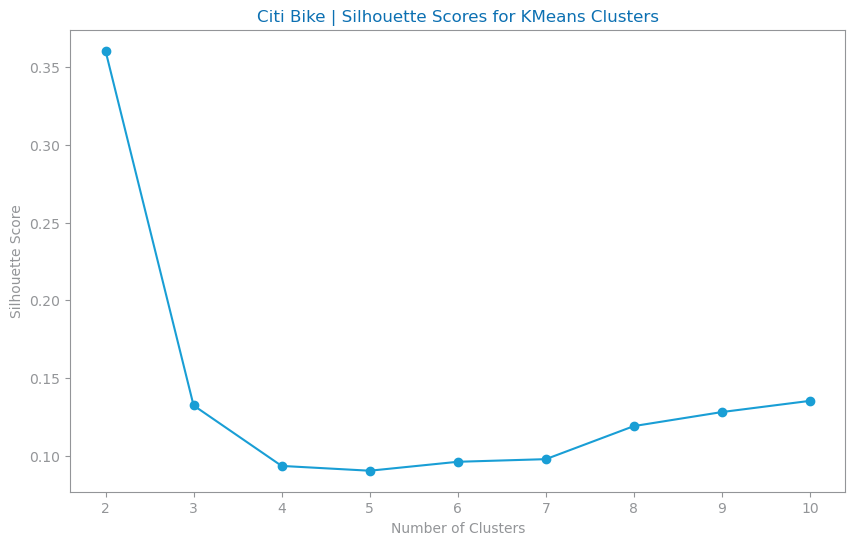

In [72]:
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Define the range of clusters to evaluate
range_n_clusters = list(range(2, 11))

# Initialize an empty list to store the silhouette scores
silhouette_scores = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title(f'{file_tag} | Silhouette Scores for KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## Kmeans model

In [73]:
# Clustering
citibike_kmeans = KMeans(n_clusters=3, random_state=42)
citibike_y_pred_kmeans = citibike_kmeans.fit_predict(df)

citibike_kmeans.cluster_centers_

array([[ 7.55830303e-02,  1.38642418e-01, -9.75961990e-01,
        -3.27713190e-01, -2.33424590e-01, -4.79590312e-01,
         5.01006431e+00,  9.53762858e-01,  4.68479975e-01,
        -9.12379175e-02,  1.94136914e-01,  1.83711991e-01,
         1.34976067e-01,  3.55466169e-01, -3.54827789e-01,
         9.80356147e-02, -1.15267503e-01, -4.98080614e-03,
         1.21258447e-01, -5.73034947e-04, -8.25910699e-02,
        -5.86559491e-02, -1.81329917e-02, -5.68468797e-03,
         1.04895573e-01, -8.10393926e-04, -7.11135532e-03,
        -6.77776943e-02, -5.71777091e-02, -1.83133047e-02,
        -6.20902588e-01,  1.77786722e+00, -2.93011395e-01,
         5.08711741e+00, -3.26421786e-01, -8.80725756e-01,
        -2.87280355e-01,  0.00000000e+00,  0.00000000e+00],
       [-3.08221685e-02,  1.50410754e-02,  1.89305060e-02,
        -4.25678980e-02, -4.03239009e-02,  8.50153270e-03,
        -1.53485387e-01, -3.72280798e-04, -1.89299195e-02,
        -9.07873090e-02, -4.02284288e-02,  3.18026015e-

## Hierarchical Clustering - Agglomerative

## Sillouette Study for Agglomerative

In [75]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

def evaluate_agglomerative_clustering(X, 
                                      n_clusters_list=[2, 3, 4, 5], 
                                      metric_list=['euclidean', 'manhattan', 'cosine'], 
                                      linkage_list=['ward', 'complete', 'average', 'single'],
                                      scale='no',
                                      title='Silhouette Scores for Different Clustering Parameters'):
    # Scale the data if required
    if scale == 'yes':
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Store the results
    results = []

    for n_clusters in n_clusters_list:
        for metric in metric_list:
            for linkage in linkage_list:
                if linkage == 'ward' and metric != 'euclidean':
                    continue  # Ward linkage only works with Euclidean distance
                clustering = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage=linkage)
                labels = clustering.fit_predict(X)
                score = silhouette_score(X, labels)
                results.append((n_clusters, metric, linkage, score))

    # Convert results to a structured array for easy plotting
    dtype = [('n_clusters', int), ('metric', 'U10'), ('linkage', 'U10'), ('score', float)]
    results = np.array(results, dtype=dtype)

    # Plot the results
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
    axes = axes.flatten()
    
    for ax, linkage in zip(axes, linkage_list):
        for metric in metric_list:
            subset = results[(results['metric'] == metric) & (results['linkage'] == linkage)]
            ax.plot(subset['n_clusters'], subset['score'], label=f'{metric}')
            for (n_clusters, score) in zip(subset['n_clusters'], subset['score']):
                ax.text(n_clusters, score, f'{score:.2f}', fontsize=8, ha='right')
        
        ax.set_title(f'Linkage: {linkage}')
        ax.set_xlabel('Number of Clusters')
        ax.set_ylabel('Silhouette Score')
        ax.legend(loc='upper right')
        ax.set_xticks(n_clusters_list)
        ax.set_xticklabels([str(n) for n in n_clusters_list])
    
    fig.suptitle(title, fontsize=16)
    plt.show()

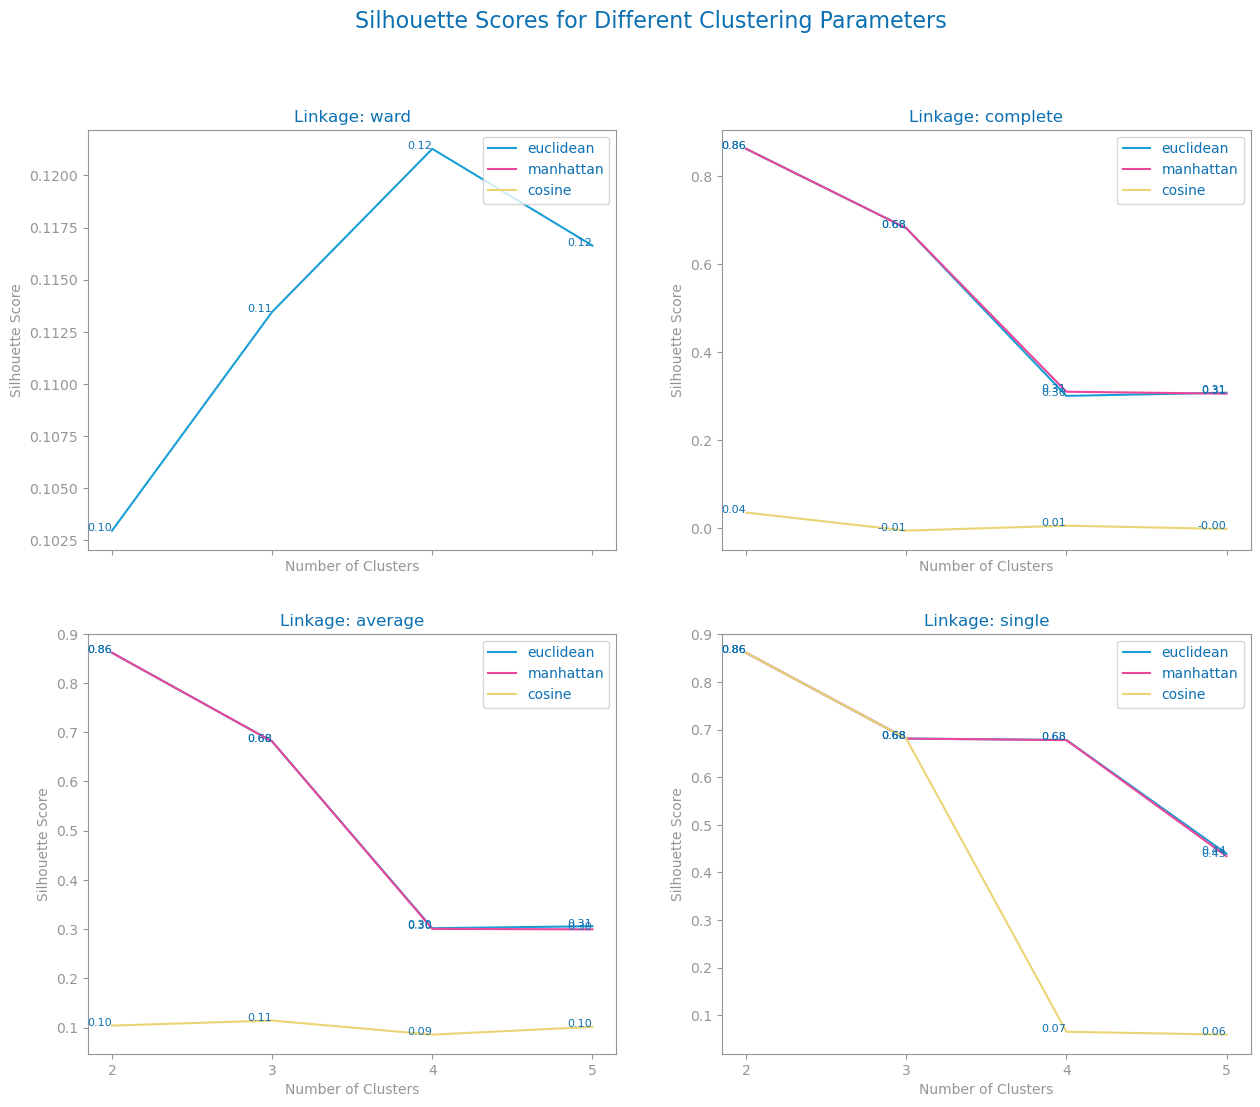

In [76]:
# available in data functions py

evaluate_agglomerative_clustering(df, n_clusters_list=[2, 3, 4, 5], scale='no')

## Dendrogram

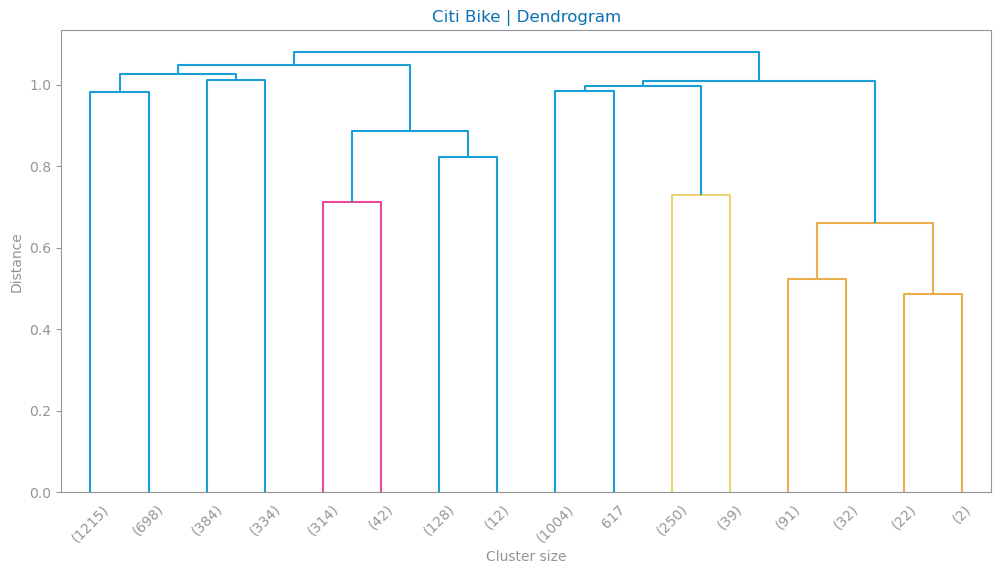

In [77]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the linkage matrix
Z = linkage(df, method='average', metric='cosine')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=3, leaf_rotation=45., leaf_font_size=10., count_sort='descending', distance_sort = 'descending'), 
plt.title(f'{file_tag} | Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()


## Agglomerative Model

In [78]:
from sklearn.cluster import AgglomerativeClustering

citibike_agglo = AgglomerativeClustering(n_clusters=3, metric='cosine', linkage='average' )
citibike_y_pred_agglo = citibike_agglo.fit_predict(df)

citibike_y_pred_agglo

array([1, 0, 0, ..., 2, 0, 0])

# Clustering approaches Evaluation

In [79]:

from sklearn.metrics import silhouette_score, adjusted_rand_score


# Intrinsic Evaluation
silhouette_kmeans = silhouette_score(df, citibike_y_pred_kmeans)
silhouette_agglo = silhouette_score(df, citibike_y_pred_agglo)

print(f'Silhouette Score for KMeans: {silhouette_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')



Silhouette Score for KMeans: 0.13225029641480096
Silhouette Score for Agglomerative Clustering: 0.11424937187998654


## Cluster Labeling

In [80]:
# Add cluster labels to the dataframe
df['kmeans_cluster'] = citibike_y_pred_kmeans
df['agglo_cluster'] = citibike_y_pred_agglo

# Display the dataframe with the new cluster labels
df.head()

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,...,wmo_weather_desc_Drizzle: Dense,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Moderate,wmo_weather_desc_Rain: Slight,kmeans_cluster,agglo_cluster
1649771,0.734355,0.47181,-0.327488,1.624176,-0.736446,0.606241,-0.276738,-0.563427,0.563301,-0.741085,...,-0.047072,-0.293011,-0.179185,-0.326422,1.135427,-0.28728,0.0,0.0,2,1
802289,0.734355,0.47181,-1.549377,-0.615697,-0.184104,-1.619980,-0.276738,-0.099277,-0.633275,0.476781,...,-0.047072,-0.293011,-0.179185,-0.326422,1.135427,-0.28728,0.0,0.0,1,0
1831412,0.734355,0.47181,1.260969,1.624176,-0.944513,-0.007889,-0.276738,-0.563427,-0.056103,-0.951029,...,-0.047072,-0.293011,-0.179185,-0.326422,1.135427,-0.28728,0.0,0.0,1,0
1167620,-1.361738,0.47181,-0.449677,1.624176,2.300473,-0.794743,0.453916,0.219826,2.365204,1.916206,...,-0.047072,3.412837,-0.179185,-0.326422,-0.880726,-0.28728,0.0,0.0,2,2
1464042,-1.361738,0.47181,-0.694055,-0.615697,0.311446,0.721390,-0.276738,-0.273333,0.830771,0.738047,...,-0.047072,-0.293011,-0.179185,-0.326422,1.135427,-0.28728,0.0,0.0,2,0


### User Order Cluster Counts

In [81]:
# Group by kmeans_cluster and count the number of user IDs
kmeans_cluster_counts = df.groupby('kmeans_cluster').size()

# Group by agglo_cluster and count the number of user IDs
agglo_cluster_counts = df.groupby('agglo_cluster').size()

print("KMeans Cluster Counts:")
print(kmeans_cluster_counts)

print("\nAgglomerative Clustering Counts:")
print(agglo_cluster_counts)

KMeans Cluster Counts:
kmeans_cluster
0     140
1    2636
2    1792
dtype: int64

Agglomerative Clustering Counts:
agglo_cluster
0    2631
1    1441
2     496
dtype: int64


In [82]:
agglo_weird_cluster = df[df['agglo_cluster']==1]

agglo_weird_cluster

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,...,wmo_weather_desc_Drizzle: Dense,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Moderate,wmo_weather_desc_Rain: Slight,kmeans_cluster,agglo_cluster
1649771,0.734355,0.471810,-0.327488,1.624176,-0.736446,0.606241,-0.276738,-0.563427,0.563301,-0.741085,...,-0.047072,-0.293011,-0.179185,-0.326422,1.135427,-0.28728,0.0,0.0,2,1
2303171,0.734355,0.471810,-0.327488,1.624176,1.305656,1.661777,-0.276738,-0.563427,1.013777,1.820417,...,-0.047072,-0.293011,-0.179185,-0.326422,1.135427,-0.28728,0.0,0.0,2,1
2967752,-1.361738,0.471810,1.627536,-0.615697,-0.632943,0.798156,-0.276738,2.308500,-1.027442,-0.679057,...,-0.047072,-0.293011,-0.179185,-0.326422,1.135427,-0.28728,0.0,0.0,2,1
350709,0.734355,-2.119496,-0.083110,-0.615697,2.622504,1.028455,-0.276738,-0.563427,0.070593,-0.940641,...,-0.047072,-0.293011,-0.179185,-0.326422,-0.880726,-0.28728,0.0,0.0,2,1
42458,0.734355,0.471810,-0.327488,1.624176,0.193032,1.661777,-0.276738,-0.563427,1.013777,1.817212,...,-0.047072,-0.293011,-0.179185,-0.326422,1.135427,-0.28728,0.0,0.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467158,0.734355,0.471810,1.260969,1.624176,-0.833494,-0.852318,-0.276738,0.741995,-0.478424,-0.659664,...,-0.047072,-0.293011,-0.179185,-0.326422,1.135427,-0.28728,0.0,0.0,2,1
61314,0.734355,0.471810,-0.938433,-0.615697,0.522552,0.241601,-0.276738,-0.563427,-0.168722,0.857240,...,-0.047072,-0.293011,-0.179185,-0.326422,1.135427,-0.28728,0.0,0.0,2,1
668968,0.734355,0.471810,-0.327488,1.624176,0.149020,0.606241,-0.276738,-0.563427,0.563301,-0.212596,...,-0.047072,-0.293011,-0.179185,-0.326422,1.135427,-0.28728,0.0,0.0,2,1
1317626,0.734355,-2.119496,1.627536,-0.615697,-0.866148,-0.180613,-0.276738,2.250481,-0.703662,-0.549230,...,-0.047072,-0.293011,-0.179185,-0.326422,1.135427,-0.28728,0.0,0.0,2,1


## DBSCAN Clustering - density-based

### User Order cluster boxplots

In [83]:

import seaborn as sns

def plot_cluster_boxplots(dataframe, features, cluster_labels):
    """
    Plots boxplots for the given features in the dataframe, comparing the specified cluster labels.

    Parameters:
    dataframe (pd.DataFrame): The dataframe containing the data.
    features (list): List of features to plot.
    cluster_labels (list): List of cluster labels to compare.
    """
    # Create subplots
    fig, axes = plt.subplots(nrows=len(features), ncols=len(cluster_labels), figsize=(15, 5 * len(features)))

    # Loop through each feature and create boxplots
    for i, feature in enumerate(features):
        for j, cluster_label in enumerate(cluster_labels):
            sns.boxplot(x=cluster_label, y=feature, data=dataframe, ax=axes[i, j])
            axes[i, j].set_title(f'{cluster_label} - {feature}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

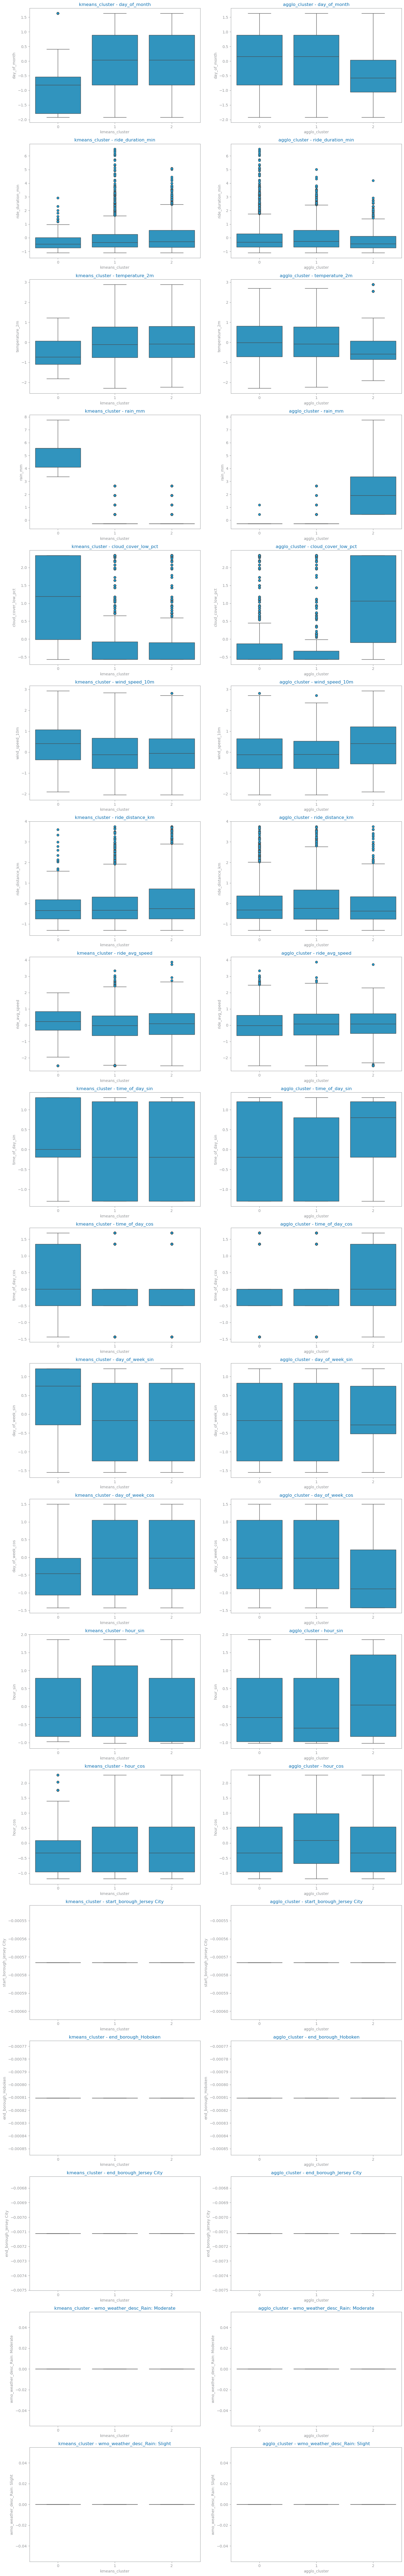

In [84]:
# Example usage
features = numeric


cluster_labels = ['kmeans_cluster', 'agglo_cluster']
plot_cluster_boxplots(df, features, cluster_labels)

## User Order PCA visualization

In [92]:
from sklearn.decomposition import PCA

#df.drop(columns=['kmeans_cluster', 'agglo_cluster'], inplace=True)

# Visualization
pca_reorder = PCA(n_components=10)
numeric_features_pca = pca_reorder.fit_transform(df)

pca_reorder_df = pd.DataFrame(numeric_features_pca, columns=[f'PC{i+1}' for i in range(numeric_features_pca.shape[1])])
pca_reorder_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1.784242,-0.934575,-1.649930,-1.299035,5.869532,-0.756795,-1.138364,1.556310,-0.727789,1.149472
1,-1.387167,1.094424,1.697561,0.604577,-0.267158,-1.830333,-0.137133,0.665507,0.939223,-1.756416
2,-1.318484,-0.175457,-1.692886,-1.619367,0.364394,-1.539722,0.045964,-0.601589,-0.470323,1.192364
3,0.640889,0.690099,-3.642028,0.929101,-1.331075,-1.188787,-0.597203,0.710648,-2.382021,0.864494
4,0.498738,0.049914,-1.765100,-0.538479,-0.217326,0.109572,-0.012863,-0.619923,0.693504,-1.300645


In [86]:
df.shape

(4568, 41)

## User Order pca explained variance ratio

In [93]:
# Fit the PCA model


pca_reorder.fit(df)

# Explained variance ratio
explained_variance_reorder = pca_reorder.explained_variance_ratio_
total_variance_explained = explained_variance_reorder.sum()

print(f'Explained variance ratio: {explained_variance_reorder}')
print(f'Total variance explained: {total_variance_explained:.4f}')


Explained variance ratio: [0.10208426 0.08704319 0.0747871  0.06700668 0.05851309 0.05544166
 0.05202208 0.05017648 0.04768378 0.04649904]
Total variance explained: 0.6413


In [94]:
df.columns
df.shape

(4568, 39)

## PCA plot

### 2D PCA Plot

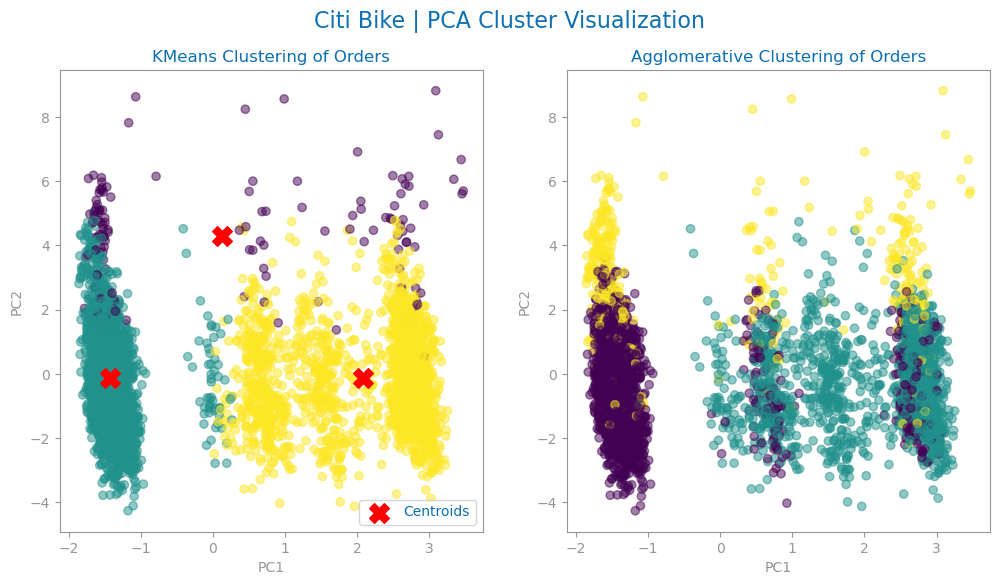

In [95]:
plt.figure(figsize=(12, 6))

# KMeans Clustering
plt.subplot(121)
plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=citibike_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids = pca_reorder.transform(citibike_kmeans.cluster_centers_)
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering of Orders')
plt.legend()

# Agglomerative Clustering
plt.subplot(122)
plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=citibike_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative Clustering of Orders')

plt.suptitle(f"{file_tag} | PCA Cluster Visualization", fontsize=16)

plt.show()

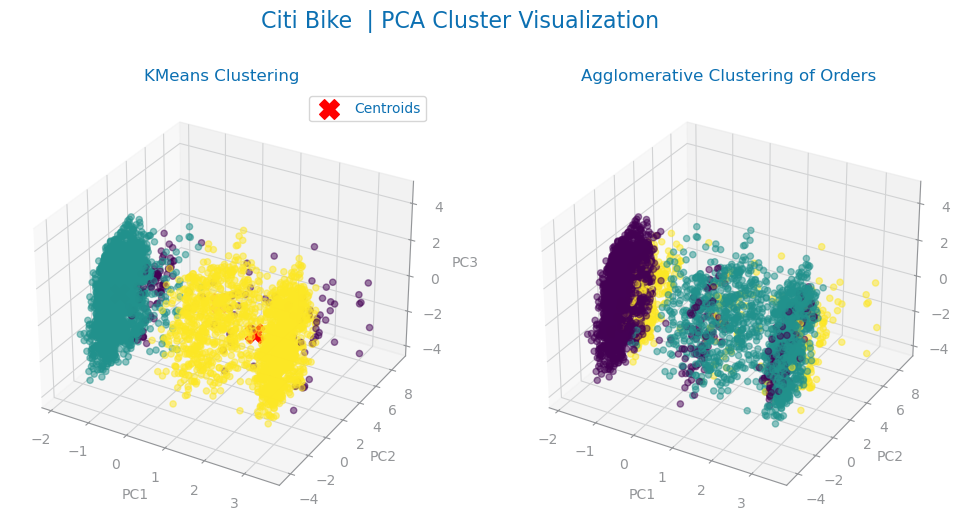

In [96]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))

# KMeans Clustering
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=citibike_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids_3d = pca_reorder.transform(citibike_kmeans.cluster_centers_)
ax.scatter(kmeans_centroids_3d[:, 0], kmeans_centroids_3d[:, 1], kmeans_centroids_3d[:, 2], c='red', marker='X', s=200, label='Centroids')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('KMeans Clustering')
ax.legend()

# Agglomerative Clustering
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=citibike_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Agglomerative Clustering of Orders')

fig.suptitle(f"{file_tag}  | PCA Cluster Visualization", fontsize=16)

plt.show()